# **PlantCare - Chili Leaf Disease Detection**


## **Collecting Data**

### 1. Setting Up Kaggle API for Dataset Access

In [1]:
pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!chmod 600 ~/.kaggle/'kaggle.json'

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


###2. Listing and Downloading Dataset for Kaggle


In [5]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [6]:
!kaggle datasets download -d 'dhenyd/chili-plant-disease'

Dataset URL: https://www.kaggle.com/datasets/dhenyd/chili-plant-disease
License(s): unknown
100% 4.94M/4.94M [00:00<00:00, 42.6MB/s]
100% 4.94M/4.94M [00:00<00:00, 42.4MB/s]


###3. Extracting

In [7]:
import zipfile
import os
import shutil

In [8]:
dataset_zip = zipfile.ZipFile('chili-plant-disease.zip','r')
dataset_zip.extractall()
dataset_zip.close()

###4. Importing Required Libraries

In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19
from tensorflow.keras import regularizers


##Cleaning and Formatting Data

In [10]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/content/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

Found 400 files belonging to 5 classes.


In [11]:
from tensorflow.keras import layers

preprocessing_layers = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [12]:
train_data = train_data.map(lambda x, y: (preprocessing_layers(x), y))

In [13]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

Found 50 files belonging to 5 classes.


In [14]:
val_data = val_data.map(lambda x, y: (preprocessing_layers(x), y))

##Augmentation Data

In [15]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

##Dataset Preparation: Training, Validation, and Evaluation

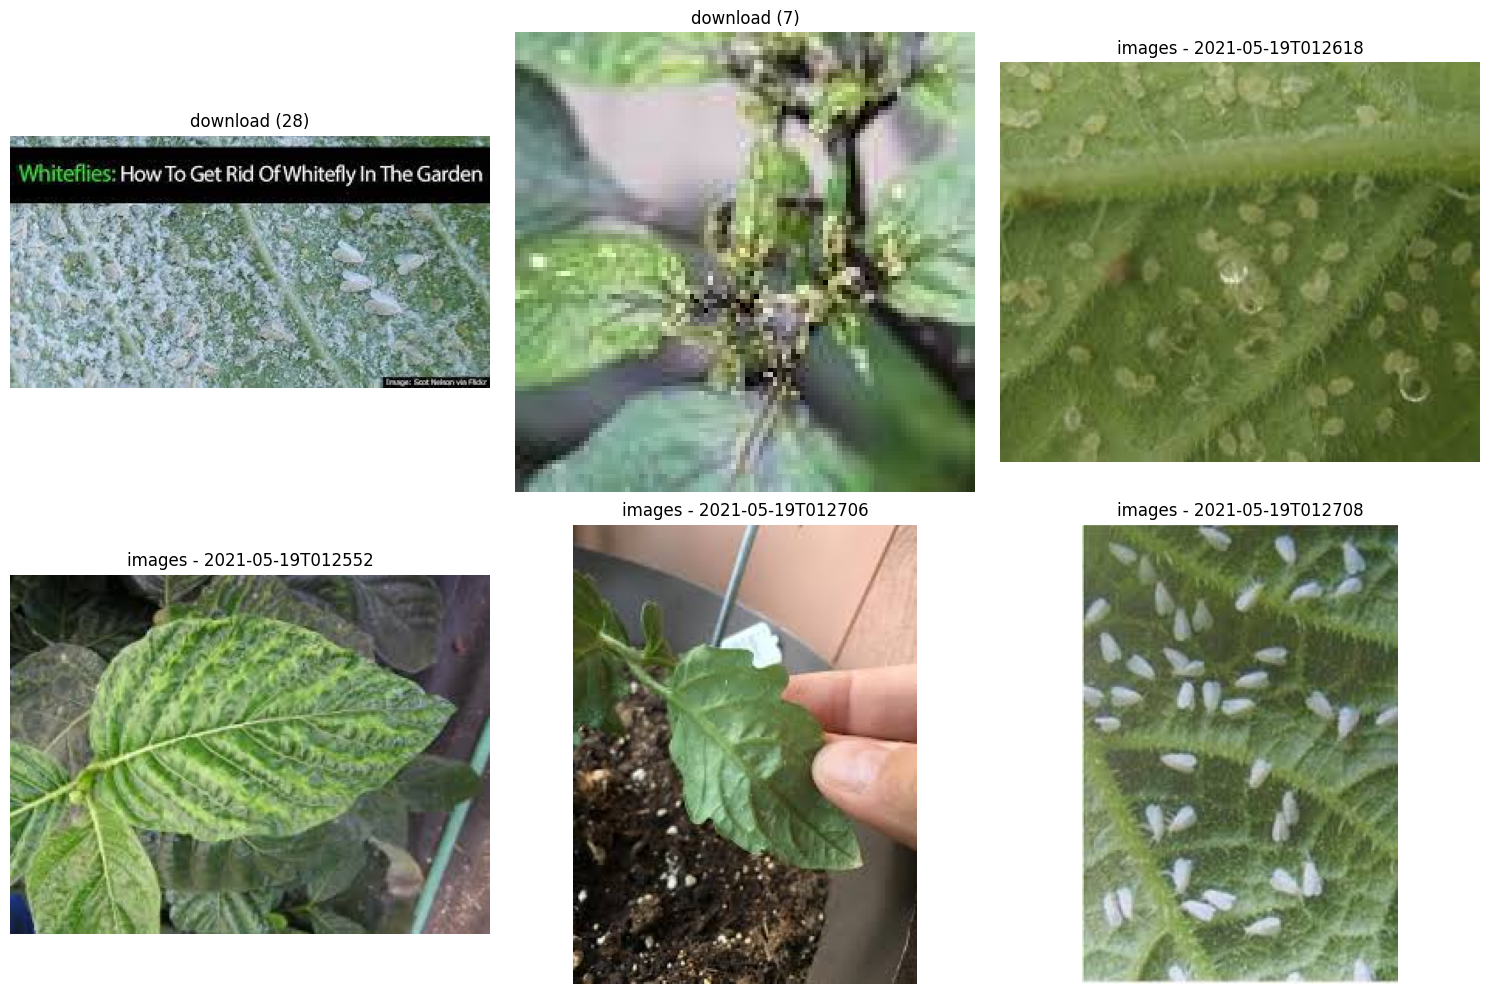

In [16]:
path = "/content/train/whitefly"

image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    image_file = image_files[i]
    label = image_file.split('.')[0]

    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

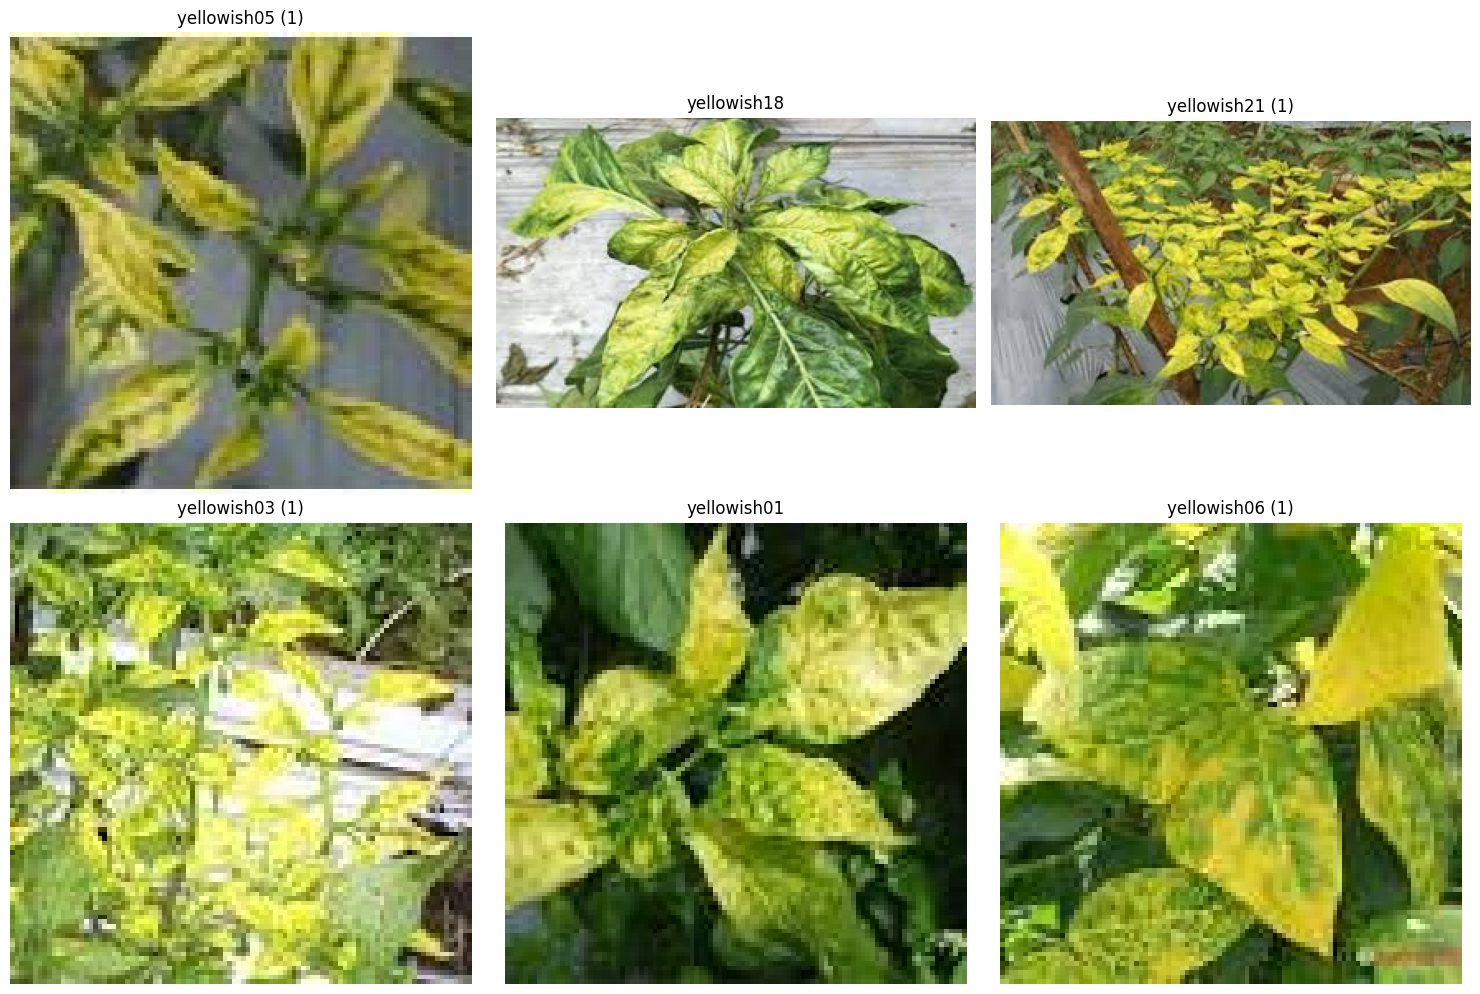

In [17]:
# Path to the directory containing images
path = "/content/test/yellowish"

# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [18]:
conv_base = DenseNet121(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3),
    pooling='avg'
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
conv_base.trainable = False

In [20]:
model = Sequential()
model.add(conv_base)
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())
model.add(Dense(120, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

##Model Training and Evaluation

In [22]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.93:
                print("\nReached 95% validation accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [23]:
history = model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[callbacks]
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.1938 - loss: 1.8776 - val_accuracy: 0.2400 - val_loss: 1.5466
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 713ms/step - accuracy: 0.3011 - loss: 1.6471 - val_accuracy: 0.3200 - val_loss: 1.4195
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 722ms/step - accuracy: 0.4124 - loss: 1.4020 - val_accuracy: 0.4400 - val_loss: 1.3359
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 776ms/step - accuracy: 0.5379 - loss: 1.2554 - val_accuracy: 0.5200 - val_loss: 1.2775
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 678ms/step - accuracy: 0.5381 - loss: 1.1916 - val_accuracy: 0.6400 - val_loss: 1.1679
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 717ms/step - accuracy: 0.6089 - loss: 1.1289 - val_accuracy: 0.7800 - val_loss: 1.0922
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 726ms/step - accuracy: 0.6181 - loss: 0.9837 - val_accuracy: 0.6400 - val_loss: 1.0702
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 784ms/step - accuracy: 0.5701 - loss: 0.9930 - val_ac

In [24]:
evaluation = model.evaluate(val_data)

print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - accuracy: 0.8650 - loss: 0.3698
Validation Loss: 0.36788153648376465
Validation Accuracy: 0.8600000143051147


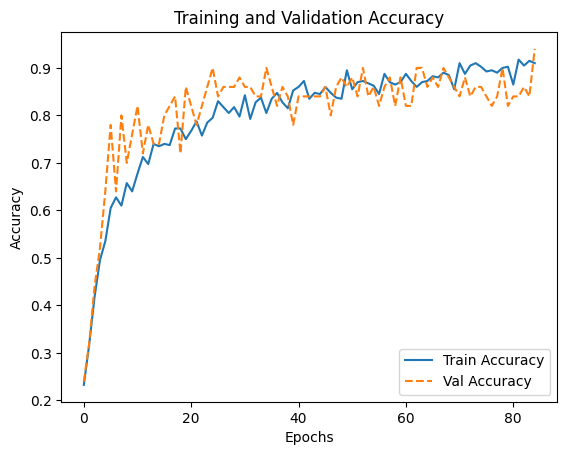

In [25]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


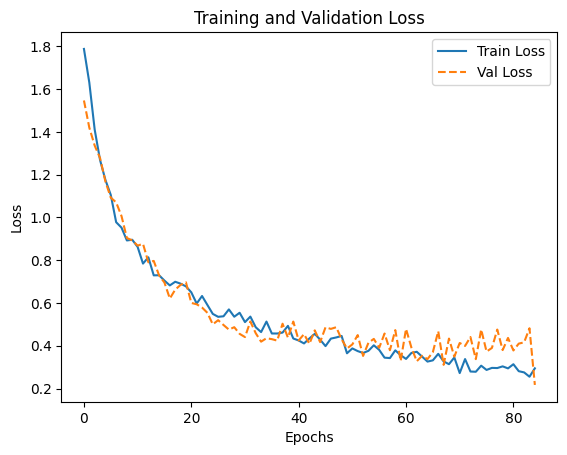

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

##Prediction Test

In [27]:
from ipywidgets import widgets
from io import BytesIO
import numpy as np
rescale_layer = tf.keras.layers.Rescaling(1./255)

uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""

    image = tf.keras.utils.load_img(file, target_size=(256, 256))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)


    prediction = model.predict(image, verbose=0)


    class_names = ['Healthy', 'leaf curl', 'leaf spot', 'whitefly', 'yellowish']


    predicted_class = np.argmax(prediction)

    with out:
        print(f"{filename} termasuk dalam kelas '{class_names[predicted_class]}' dengan probabilitas {prediction[0][predicted_class]:.2f}")

    for i, class_name in enumerate(class_names):
        print(f"Probabilitas untuk {class_name}: {prediction[0][i]:.4f}")


def on_upload_change(change):
    """ A function for getting files from the widget and running the prediction."""
    items = change.new
    for filename, file_data in items.items():
        file_jpgdata = BytesIO(file_data['content'])
        file_predict(filename, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

Probabilitas untuk Healthy: 0.0000
Probabilitas untuk leaf curl: 0.0000
Probabilitas untuk leaf spot: 1.0000
Probabilitas untuk whitefly: 0.0000
Probabilitas untuk yellowish: 0.0000
Probabilitas untuk Healthy: 0.0001
Probabilitas untuk leaf curl: 0.0000
Probabilitas untuk leaf spot: 0.0283
Probabilitas untuk whitefly: 0.9716
Probabilitas untuk yellowish: 0.0000


##Save the model

In [28]:
model.save('chili_plant_care.h5')

In [29]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

model = load_model('/content/chili_plant_care.h5')

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          30,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             605 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,336,471 (27.99 MB)

 Trainable params: 296,405 (1.13 MB)

 Non-trainable params: 7,040,064 (26.86 MB)

 Optimizer params: 2 (12.00 B)

In [30]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

Saved artifact at '/tmp/tmpji9kja2n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139637347020192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139637347098944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139637347101056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139637347094016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139637347096656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139637347105632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139637470188416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139637347126256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139637347128544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139637470199328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1396374702218

In [31]:
tflite_name = 'tf_lite_model_chili.tflite'

with open(tflite_name, 'wb') as f:
  f.write(tflite_model)